# Simulace přistávání dronu

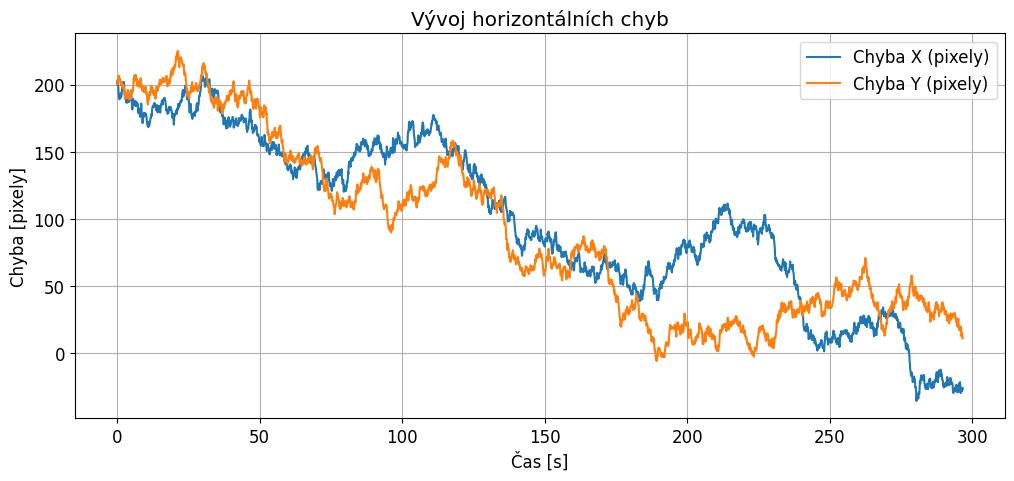

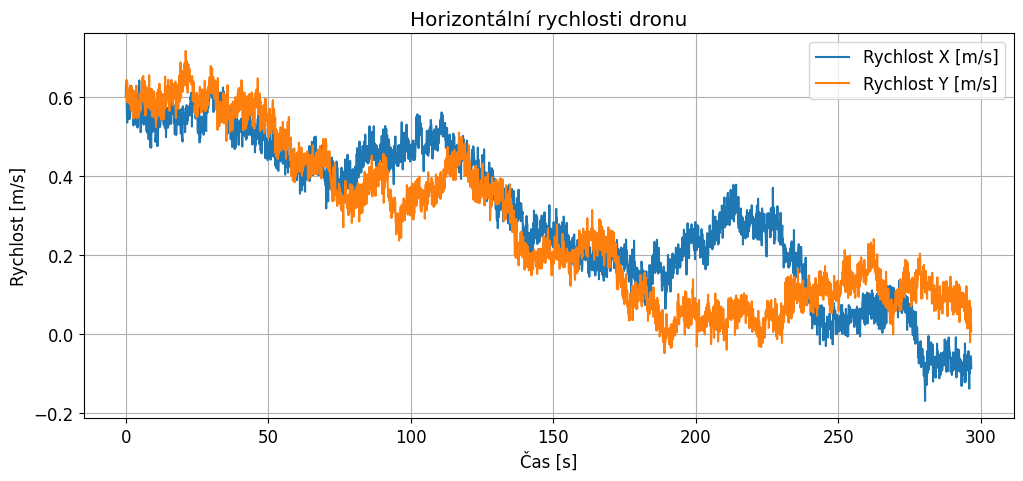

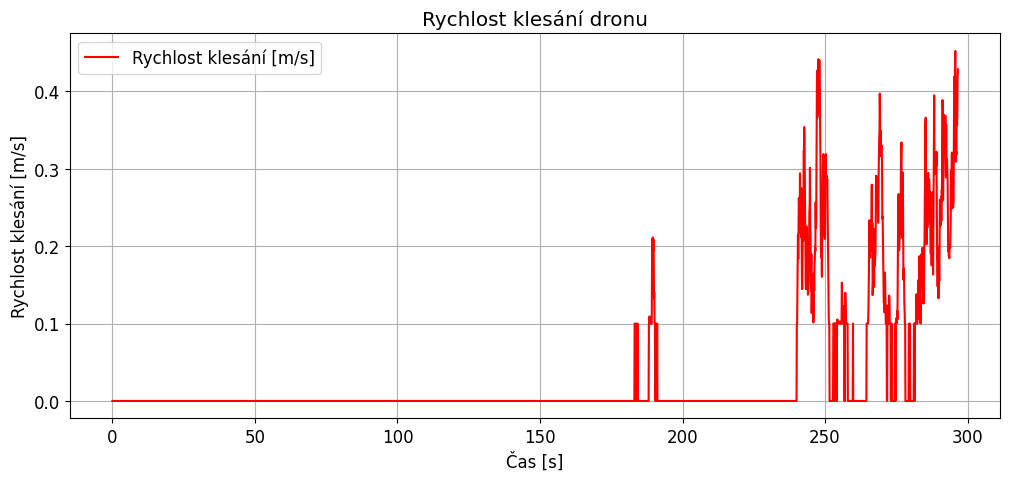

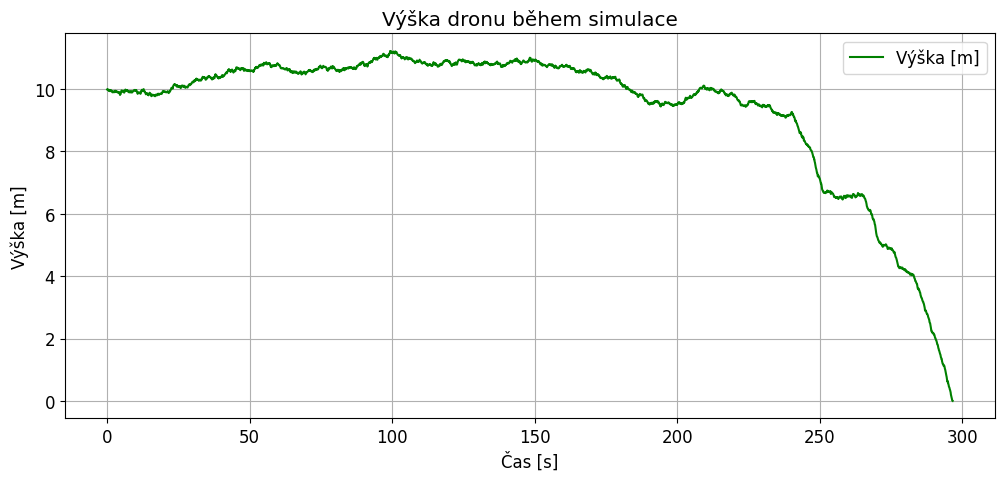

In [5]:
# Import potřebných knihoven
import numpy as np
import matplotlib.pyplot as plt
import time

# =============================
# Parametry regulace a simulace
# =============================

# PID parametry (stejné jako v DroneController)
Kp_xy = 0.3
Ki_xy = 0.001
Kd_xy = 0.1

# Omezení integrální složky
integral_windup_limit = 100

# Škálovací faktor pro převod PID výstupu na rychlost [m/s]
scale_factor = 0.01

# Parametry pro výpočet rychlosti klesání
position_threshold = 50     # Pixelů - pokud je celková chyba menší, dovolíme klesat
max_descent_rate = 1.0      # maximální rychlost klesání [m/s]

# Simulační parametry
dt = 0.1                    # časový krok [s]
noise_error_std = 2.0       # šum v horizontální chybě (v pixelech)
noise_altitude_std = 0.02   # šum ve výšce (v metrech)

# Počáteční podmínky
error_x = 200.0   # počáteční chyba v ose X (v pixelech)
error_y = 200.0   # počáteční chyba v ose Y (v pixelech)
altitude = 10.0   # počáteční výška [m]

# Inicializace PID stavových proměnných
integral_x = 0.0
integral_y = 0.0
last_error_x = error_x
last_error_y = error_y

# Pro ukládání výsledků pro grafiku
times = []
errors_x = []
errors_y = []
velocities_x = []
velocities_y = []
descent_rates = []
altitudes = []

# Počáteční čas
t = 0.0

# =============================
# Definice funkcí
# =============================

def calculate_pid_control(error_x, error_y, dt, last_error_x, last_error_y, integral_x, integral_y):
    """
    Vypočítá PID výstupy pro horizontální osy X a Y.
    Vrací: (output_x, output_y, aktualizovaný_integral_x, aktualizovaný_integral_y, nový_last_error_x, nový_last_error_y)
    """
    # Aktualizace integrálních složek s anti-windup omezením
    integral_x += error_x * dt
    integral_x = max(min(integral_x, integral_windup_limit), -integral_windup_limit)
    derivative_x = (error_x - last_error_x) / dt
    output_x = Kp_xy * error_x + Ki_xy * integral_x + Kd_xy * derivative_x

    integral_y += error_y * dt
    integral_y = max(min(integral_y, integral_windup_limit), -integral_windup_limit)
    derivative_y = (error_y - last_error_y) / dt
    output_y = Kp_xy * error_y + Ki_xy * integral_y + Kd_xy * derivative_y

    return output_x, output_y, integral_x, integral_y, error_x, error_y

def calculate_descent_rate(error_x, error_y):
    """
    Vypočítá rychlost klesání podle celkové horizontální chyby.
    Pokud je celková chyba menší než position_threshold, umožní rychlejší klesání.
    """
    total_error = np.sqrt(error_x**2 + error_y**2)
    if total_error < position_threshold:
        # Rychlost klesání roste, když je chyba malá
        descent_rate = max_descent_rate * (1 - total_error / position_threshold)
        descent_rate = min(max(0.1, descent_rate), max_descent_rate)
    else:
        descent_rate = 0  # pokud je chyba příliš velká, nedojde ke klesání
    return descent_rate

# =============================
# Hlavní simulační smyčka
# =============================

# Simulace probíhá, dokud nedosáhneme výšky 0
while altitude > 0:
    # Ukládáme aktuální čas a měřené veličiny
    times.append(t)
    errors_x.append(error_x)
    errors_y.append(error_y)
    
    # Vypočítej PID regulované výstupy pro horizontální osy
    output_x, output_y, integral_x, integral_y, last_error_x, last_error_y = \
        calculate_pid_control(error_x, error_y, dt, last_error_x, last_error_y, integral_x, integral_y)
    
    # Rychlosti v m/s (použijeme škálovací faktor)
    vel_x = output_x * scale_factor
    vel_y = output_y * scale_factor
    velocities_x.append(vel_x)
    velocities_y.append(vel_y)
    
    # Vypočítej rychlost klesání na základě aktuální horizontální chyby
    descent_rate = calculate_descent_rate(error_x, error_y)
    descent_rates.append(descent_rate)
    
    # Aktualizace výšky (odečteme klesající rychlost, přičemž přidáme malý náhodný šum)
    altitude = max(altitude - descent_rate * dt + np.random.normal(0, noise_altitude_std), 0)
    altitudes.append(altitude)
    
    # Aktualizace horizontálních chyb:
    # Předpokládáme, že horizontální chyba se snižuje v závislosti na aplikované rychlosti
    # Přidáme malý šum, aby simulace nebyla příliš deterministická
    error_x = error_x - vel_x * dt + np.random.normal(0, noise_error_std)
    error_y = error_y - vel_y * dt + np.random.normal(0, noise_error_std)
    
    # Aktualizace času
    t += dt

# =============================
# Grafické vykreslení výsledků
# =============================

plt.rcParams.update({'font.size': 12})

# Graf horizontálních chyb
plt.figure(figsize=(12, 5))
plt.plot(times, errors_x, label='Chyba X (pixely)')
plt.plot(times, errors_y, label='Chyba Y (pixely)')
plt.xlabel('Čas [s]')
plt.ylabel('Chyba [pixely]')
plt.title('Vývoj horizontálních chyb')
plt.legend()
plt.grid(True)
plt.show()

# Graf horizontálních rychlostí (X a Y)
plt.figure(figsize=(12, 5))
plt.plot(times, velocities_x, label='Rychlost X [m/s]')
plt.plot(times, velocities_y, label='Rychlost Y [m/s]')
plt.xlabel('Čas [s]')
plt.ylabel('Rychlost [m/s]')
plt.title('Horizontální rychlosti dronu')
plt.legend()
plt.grid(True)
plt.show()

# Graf rychlosti klesání
plt.figure(figsize=(12, 5))
plt.plot(times, descent_rates, color='red', label='Rychlost klesání [m/s]')
plt.xlabel('Čas [s]')
plt.ylabel('Rychlost klesání [m/s]')
plt.title('Rychlost klesání dronu')
plt.legend()
plt.grid(True)
plt.show()

# Graf výšky dronu v čase
plt.figure(figsize=(12, 5))
plt.plot(times, altitudes, color='green', label='Výška [m]')
plt.xlabel('Čas [s]')
plt.ylabel('Výška [m]')
plt.title('Výška dronu během simulace')
plt.legend()
plt.grid(True)
plt.show()